In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.corpus import gutenberg
from bs4 import BeautifulSoup
import re


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Downloading and sanitizing the dataset
nltk.download('gutenberg')
nltk.download('stopwords')
corpus = gutenberg.raw('austen-sense.txt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\dayyapp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dayyapp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
def denoise_text(text):
    # remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # replace \n with space
    text = re.sub('\n', ' ', text)
    # remove square brackets
    text = re.sub('\[[^]]*\]', ' ', text)
    # replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    # remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # replace extra spaces with single space
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

corpus = denoise_text(corpus)
words = corpus.split()
unique_words = np.unique(words)
word_to_index = {w: i for i, w in enumerate(unique_words)}
index_to_word = {i: w for i, w in enumerate(unique_words)}
vocab_size = len(unique_words)

In [5]:
# Creating 6-grams dataset
seq_len = 6
sequences = []
for i in range(seq_len, len(words)):
    seq = words[i-seq_len:i]
    sequences.append((seq[:-1], seq[-1]))

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [7]:
# Defining the dataset
class TextDataset(Dataset):
    def __init__(self, sequences, word_to_index):
        self.sequences = sequences
        self.word_to_index = word_to_index
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        x = torch.tensor([self.word_to_index[w] for w in x])
        y = torch.tensor(self.word_to_index[y])
        return x, y

In [8]:
# Training the model
batch_size = 64
embedding_dim = 100
hidden_dim = 128
num_layers = 2
learning_rate = 0.001
num_epochs = 50

In [19]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers)
model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataset = TextDataset(sequences, word_to_index)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

LSTMModel(
  (embedding): Embedding(6330, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6330, bias=True)
)

In [20]:
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

Epoch 1 Loss: 6.0551
Epoch 2 Loss: 5.3169
Epoch 3 Loss: 4.9985
Epoch 4 Loss: 4.7452
Epoch 5 Loss: 4.5082
Epoch 6 Loss: 4.2778
Epoch 7 Loss: 4.0543
Epoch 8 Loss: 3.8366
Epoch 9 Loss: 3.6223
Epoch 10 Loss: 3.4153
Epoch 11 Loss: 3.2171
Epoch 12 Loss: 3.0295
Epoch 13 Loss: 2.8485
Epoch 14 Loss: 2.6776
Epoch 15 Loss: 2.5159
Epoch 16 Loss: 2.3634
Epoch 17 Loss: 2.2184
Epoch 18 Loss: 2.0826
Epoch 19 Loss: 1.9554
Epoch 20 Loss: 1.8353
Epoch 21 Loss: 1.7223
Epoch 22 Loss: 1.6155
Epoch 23 Loss: 1.5194
Epoch 24 Loss: 1.4258
Epoch 25 Loss: 1.3405
Epoch 26 Loss: 1.2606
Epoch 27 Loss: 1.1885
Epoch 28 Loss: 1.1187
Epoch 29 Loss: 1.0531
Epoch 30 Loss: 0.9951
Epoch 31 Loss: 0.9423
Epoch 32 Loss: 0.8898
Epoch 33 Loss: 0.8437
Epoch 34 Loss: 0.8003
Epoch 35 Loss: 0.7589
Epoch 36 Loss: 0.7252
Epoch 37 Loss: 0.6883
Epoch 38 Loss: 0.6582
Epoch 39 Loss: 0.6279
Epoch 40 Loss: 0.6035
Epoch 41 Loss: 0.5798
Epoch 42 Loss: 0.5556
Epoch 43 Loss: 0.5348
Epoch 44 Loss: 0.5087
Epoch 45 Loss: 0.4955
Epoch 46 Loss: 0.47

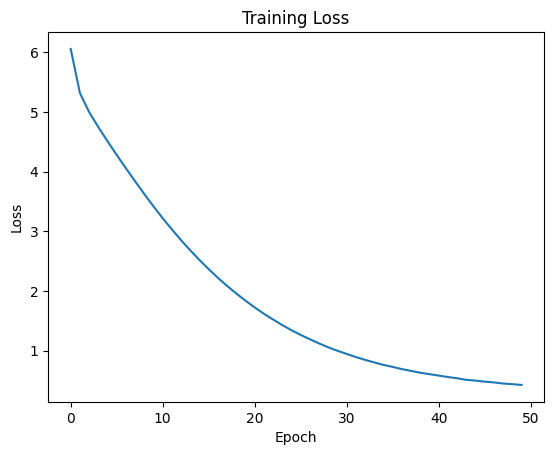

his natural shyness was overcome his earnest within be still her desire must of an interesting character as i did not i have had you your own house i believe he has no doubt that no ever is all my cousins but dear i am sure he must be looked to hear it all i am disappointed i would not go i cannot stay it again but tomorrow and that i am sure when she was staying in this extraordinary such an event no whatever she might have found me that while he might bring up the same men was on my love a few


In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# Generating text
seed = "his natural shyness was overcome"
generated_text = seed

for i in range(100):
    seq = generated_text.split()[-6:]
    seq_idx = torch.tensor([word_to_index[w] for w in seq]).unsqueeze(0)
    pred_idx = model(seq_idx.to(device)).argmax(dim=1).item()
    pred_word = index_to_word[pred_idx]
    generated_text += " " + pred_word

print(generated_text)